# Hoja de Trabajo 2
# Deep Learning

Autores:

- Nelson García 22434
- Joaquín Puente 22296

## Ejercicio 1 - Experimentación Práctica

### Task 1: Preparación del conjunto de datos.

In [24]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [25]:
# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [26]:
# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [27]:
# 1) Cargar dataset Iris
iris = load_iris()
X = iris.data.astype(np.float32)     # sepal length/width, petal length/width
y = iris.target.astype(np.int64)     # 3 clases: setosa, versicolor, virginica
class_names = iris.target_names

In [28]:
# 2) Train/Validation split estratificado (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [29]:
# 3) Normalización (fit SOLO en train, aplicar en val)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)


In [30]:
# 4) Convertir a tensores
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t   = torch.from_numpy(X_val)
y_val_t   = torch.from_numpy(y_val)

In [31]:
# 5) Crear TensorDatasets y DataLoaders
batch_size = 16
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [32]:
# 6) Info útil para el modelado posterior
input_dim  = X_train_t.shape[1]
num_classes = len(np.unique(y))

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)}")
print(f"Input dim: {input_dim} | Num classes: {num_classes}")
print("Clases:", class_names)

Train size: 120 | Val size: 30
Input dim: 4 | Num classes: 3
Clases: ['setosa' 'versicolor' 'virginica']


## Task 2 - Arquitectura modelo

In [33]:
def get_activation(name: str) -> nn.Module:
    name = name.lower()
    if name == "relu":
        return nn.ReLU(inplace=True)
    if name == "leaky_relu":
        return nn.LeakyReLU(0.1, inplace=True)
    if name == "tanh":
        return nn.Tanh()
    if name == "gelu":
        return nn.GELU()
    if name == "elu":
        return nn.ELU(inplace=True)
    return nn.ReLU(inplace=True)

In [34]:
class MLP(nn.Module):
    """
    MLP para clasificación multiclase.
    - Capa de entrada: input_dim
    - Capas ocultas: hidden_dims (tupla/lista)
    - Activación: configurable (relu, tanh, leaky_relu, gelu, elu)
    - Capa de salida: num_classes logits (sin softmax; usarás CrossEntropyLoss)
    - Opcional: BatchNorm y Dropout
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dims=(16, 8),
        num_classes: int = 3,
        activation: str = "relu",
        dropout: float = 0.0,
        batchnorm: bool = False,
    ):
        super().__init__()
        layers = []
        prev = input_dim
        act_layer = get_activation(activation)

        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            if batchnorm:
                layers.append(nn.BatchNorm1d(h))
            # activación
            layers.append(get_activation(activation))
            # dropout opcional
            if dropout and dropout > 0:
                layers.append(nn.Dropout(p=dropout))
            prev = h

        # Capa de salida (logits)
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        # Inicialización de pesos acorde a la activación
        self._init_weights(activation)

    def _init_weights(self, activation: str):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if activation.lower() in ["relu", "leaky_relu", "elu"]:
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                elif activation.lower() in ["tanh"]:
                    nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain("tanh"))
                else:  # gelu u otras
                    nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

In [35]:
# --- Elecciones baselines (puedes cambiarlas para experimentar) ---
hidden_dims = (16, 8)       # Nº neuronas por capa oculta
activation  = "relu"        # "relu" | "leaky_relu" | "tanh" | "gelu" | "elu"
dropout     = 0.0           # 0.0 por ahora; lo usaremos en regularización luego
batchnorm   = False         # False por ahora

model = MLP(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    num_classes=num_classes,
    activation=activation,
    dropout=dropout,
    batchnorm=batchnorm
).to(device)

print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)


In [36]:
# Conteo de parámetros entrenables
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {num_params:,}")


Parámetros entrenables: 243


In [37]:
# Comprobación rápida de shapes con un batch
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    logits = model(xb)
print("Logits shape:", logits.shape)

Logits shape: torch.Size([16, 3])


## Task 3 - Funciones de Pérdida

In [38]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [39]:
def get_loss_and_transform(name: str):
    """
    Devuelve (criterion, transform) donde:
    - criterion: función de pérdida de PyTorch
    - transform(logits, y): adapta (logits, target) a lo que espera la pérdida
      y retorna (pred_for_loss, target_for_loss)
    """
    name = name.lower()
    if name in ("cross_entropy", "ce", "cross-entropy"):
        criterion = nn.CrossEntropyLoss()
        def transform(logits, y):
            # CrossEntropyLoss espera (logits, target_idx)
            return logits, y
        return criterion, transform

    if name in ("mse", "mse_loss"):
        criterion = nn.MSELoss()
        def transform(logits, y):
            # Para MSE, comparamos probabilidades softmax vs. one-hot del target
            probs = torch.softmax(logits, dim=1)
            y_onehot = torch.zeros_like(probs)
            y_onehot.scatter_(1, y.unsqueeze(1), 1.0)
            return probs, y_onehot
        return criterion, transform

    if name in ("multi_margin", "hinge", "svm"):
        # Hinge multiclass (SVM-style) incluida en PyTorch
        criterion = nn.MultiMarginLoss()  # margin=1.0 por defecto
        def transform(logits, y):
            # MultiMarginLoss espera (scores, target_idx)
            return logits, y
        return criterion, transform

    raise ValueError(f"Pérdida no soportada: {name}")



In [40]:
# Entrenamiento genérico para una pérdida dada
def train_with_loss(
    loss_name: str,
    epochs: int = 100,
    lr: float = 1e-2,
    weight_decay: float = 0.0,
):
    # Reinstanciar el modelo para cada pérdida (misma arquitectura)
    try:
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            num_classes=num_classes,
            activation=activation,
            dropout=dropout,
            batchnorm=batchnorm
        )
    except NameError:
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=(16, 8),
            num_classes=num_classes,
            activation="relu",
            dropout=0.0,
            batchnorm=False
        )

    torch.manual_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    model = MLP(**model_kwargs).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion, transform = get_loss_and_transform(loss_name)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  []
    }

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        total_loss, total_correct, total_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)

            pred_for_loss, target_for_loss = transform(logits, yb)
            loss = criterion(pred_for_loss, target_for_loss)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(dim=1) == yb).sum().item()
            total_n += xb.size(0)

        train_loss = total_loss / total_n
        train_acc  = total_correct / total_n

        # ---- EVAL ----
        model.eval()
        val_total_loss, val_correct, val_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                pred_for_loss, target_for_loss = transform(logits, yb)
                vloss = criterion(pred_for_loss, target_for_loss)
                val_total_loss += vloss.item() * xb.size(0)
                val_correct += (logits.argmax(dim=1) == yb).sum().item()
                val_n += xb.size(0)

        val_loss = val_total_loss / val_n
        val_acc  = val_correct / val_n

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if (epoch + 1) % 10 == 0 or epoch == 1:
            print(f"[{loss_name}] Epoch {epoch+1:03d} | "
                  f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f} | "
                  f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    return model, history

In [41]:
# ----- Ejecutar experimentos con distintas pérdidas -----
loss_names = ["cross_entropy", "mse", "multi_margin"]
epochs = 100
lr = 1e-2
weight_decay = 0.0

histories = {}
final_summary = []

for name in loss_names:
    print("\n" + "="*70)
    print(f"Entrenando con pérdida: {name}")
    print("="*70)
    model_trained, hist = train_with_loss(
        loss_name=name,
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay
    )
    histories[name] = hist
    final_summary.append({
        "loss": name,
        "final_train_loss": hist["train_loss"][-1],
        "final_val_loss":   hist["val_loss"][-1],
        "final_train_acc":  hist["train_acc"][-1],
        "final_val_acc":    hist["val_acc"][-1],
    })

print("\n--- Resumen final ---")
for row in final_summary:
    print(f"{row['loss']:>13} | "
          f"train_loss={row['final_train_loss']:.4f}, val_loss={row['final_val_loss']:.4f} | "
          f"train_acc={row['final_train_acc']:.3f}, val_acc={row['final_val_acc']:.3f}")



Entrenando con pérdida: cross_entropy
[cross_entropy] Epoch 002 | train_loss=0.7919, val_loss=0.6962 | train_acc=0.758, val_acc=0.800
[cross_entropy] Epoch 010 | train_loss=0.3986, val_loss=0.4194 | train_acc=0.900, val_acc=0.900
[cross_entropy] Epoch 020 | train_loss=0.1847, val_loss=0.2216 | train_acc=0.958, val_acc=0.933
[cross_entropy] Epoch 030 | train_loss=0.1034, val_loss=0.1541 | train_acc=0.975, val_acc=0.933
[cross_entropy] Epoch 040 | train_loss=0.0788, val_loss=0.1405 | train_acc=0.992, val_acc=0.933
[cross_entropy] Epoch 050 | train_loss=0.0584, val_loss=0.1151 | train_acc=0.983, val_acc=0.967
[cross_entropy] Epoch 060 | train_loss=0.0464, val_loss=0.1157 | train_acc=0.983, val_acc=0.967
[cross_entropy] Epoch 070 | train_loss=0.0444, val_loss=0.1085 | train_acc=0.975, val_acc=0.967
[cross_entropy] Epoch 080 | train_loss=0.0363, val_loss=0.1527 | train_acc=0.975, val_acc=0.967
[cross_entropy] Epoch 090 | train_loss=0.0253, val_loss=0.1423 | train_acc=0.992, val_acc=0.967
[

## Task 4 - Técnicas de Regularización

In [42]:
# ---------- Utilidades ----------
def l1_penalty(model: nn.Module, exclude_bias: bool = True):
    """Suma de |w| sobre los parámetros (opcionalmente excluye bias y batchnorm scales)."""
    l1 = 0.0
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if exclude_bias and (".bias" in name or "bn" in name.lower()):
            continue
        l1 = l1 + p.abs().sum()
    return l1

def make_model(dropout: float):
    """Instancia el MLP usando los hiperparámetros definidos en Task 2."""
    try:
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            num_classes=num_classes,
            activation=activation,
            dropout=dropout,
            batchnorm=batchnorm
        )
    except NameError:
        # Fallback si no existen variables de Task 2
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=(16, 8),
            num_classes=num_classes,
            activation="relu",
            dropout=dropout,
            batchnorm=False
        )
    torch.manual_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    return MLP(**model_kwargs).to(device)

def train_with_regularization(
    loss_name: str = "cross_entropy",
    epochs: int = 120,
    lr: float = 1e-2,
    dropout_p: float = 0.0,
    l2_weight_decay: float = 0.0,
    l1_lambda: float = 0.0,
    early_stopping: bool = False,
    patience: int = 20,
):
    """
    Entrena el modelo con las técnicas de regularización especificadas.
    - L2: via weight_decay del optimizador
    - L1: sum(|w|) añadido a la pérdida con coeficiente l1_lambda
    - Dropout: probabilidad 'dropout_p' en el MLP
    - Early Stopping (opcional): sobre val_loss con 'patience'
    """
    model = make_model(dropout=dropout_p)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_weight_decay)
    criterion, transform = get_loss_and_transform(loss_name)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val = float("inf")
    best_state = None
    bad_epochs = 0

    for epoch in range(epochs):
        # ----- TRAIN -----
        model.train()
        total_loss, total_correct, total_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            logits = model(xb)
            pred_for_loss, target_for_loss = transform(logits, yb)
            loss = criterion(pred_for_loss, target_for_loss)

            # L1 (si corresponde)
            if l1_lambda and l1_lambda > 0:
                loss = loss + l1_lambda * l1_penalty(model, exclude_bias=True)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(dim=1) == yb).sum().item()
            total_n += xb.size(0)

        train_loss = total_loss / total_n
        train_acc  = total_correct / total_n

        # ----- EVAL -----
        model.eval()
        val_total_loss, val_correct, val_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                pred_for_loss, target_for_loss = transform(logits, yb)
                vloss = criterion(pred_for_loss, target_for_loss)
                # Nota: NO añadimos L1 en validación (se evalúa el loss "puro" del criterio)
                val_total_loss += vloss.item() * xb.size(0)
                val_correct += (logits.argmax(dim=1) == yb).sum().item()
                val_n += xb.size(0)

        val_loss = val_total_loss / val_n
        val_acc  = val_correct / val_n

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Early stopping opcional
        if early_stopping:
            if val_loss < best_val - 1e-6:
                best_val = val_loss
                best_state = deepcopy(model.state_dict())
                bad_epochs = 0
            else:
                bad_epochs += 1
                if bad_epochs >= patience:
                    print(f"(Early Stopping) Epoch {epoch+1}: sin mejora por {patience} épocas.")
                    break

        # Logging
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"[dropout={dropout_p:.2f} | L2={l2_weight_decay:.1e} | L1={l1_lambda:.1e}] "
                  f"Epoch {epoch+1:03d} | "
                  f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f} | "
                  f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    # Cargar mejor estado si usamos early stopping
    if early_stopping and best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [43]:
# ---------- Experimentos ----------
base_loss = "cross_entropy"

configs = {
    "baseline_sin_reg":   dict(dropout_p=0.0, l2_weight_decay=0.0,  l1_lambda=0.0,  early_stopping=False),
    "solo_L2_1e-3":       dict(dropout_p=0.0, l2_weight_decay=1e-3, l1_lambda=0.0,  early_stopping=False),
    "solo_L1_1e-4":       dict(dropout_p=0.0, l2_weight_decay=0.0,  l1_lambda=1e-4, early_stopping=False),
    "solo_Dropout_0.30":  dict(dropout_p=0.30,l2_weight_decay=0.0,  l1_lambda=0.0,  early_stopping=False),
    "combo_L1+L2+DO":     dict(dropout_p=0.25,l2_weight_decay=1e-3, l1_lambda=1e-4, early_stopping=True),
}

epochs = 140
lr = 1e-2

histories_reg = {}
summary_reg = []

for name, cfg in configs.items():
    print("\n" + "="*80)
    print(f"Entrenando configuración: {name}")
    print("="*80)
    model_reg, hist = train_with_regularization(
        loss_name=base_loss,
        epochs=epochs,
        lr=lr,
        **cfg
    )
    histories_reg[name] = hist
    summary_reg.append({
        "config": name,
        "final_train_loss": hist["train_loss"][-1],
        "final_val_loss":   hist["val_loss"][-1],
        "final_train_acc":  hist["train_acc"][-1],
        "final_val_acc":    hist["val_acc"][-1],
        "gap_acc":          hist["train_acc"][-1] - hist["val_acc"][-1],  # indicio de overfitting
    })

print("\n--- Resumen Regularización ---")
for row in summary_reg:
    print(f"{row['config']:<18} | "
          f"train_loss={row['final_train_loss']:.4f}, val_loss={row['final_val_loss']:.4f} | "
          f"train_acc={row['final_train_acc']:.3f}, val_acc={row['final_val_acc']:.3f} | "
          f"gap_acc(train-val)={row['gap_acc']:.3f}")


Entrenando configuración: baseline_sin_reg
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 001 | train_loss=1.0716, val_loss=0.8357 | train_acc=0.358, val_acc=0.700
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 010 | train_loss=0.3986, val_loss=0.4194 | train_acc=0.900, val_acc=0.900
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 020 | train_loss=0.1847, val_loss=0.2216 | train_acc=0.958, val_acc=0.933
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 030 | train_loss=0.1034, val_loss=0.1541 | train_acc=0.975, val_acc=0.933
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 040 | train_loss=0.0788, val_loss=0.1405 | train_acc=0.992, val_acc=0.933
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 050 | train_loss=0.0584, val_loss=0.1151 | train_acc=0.983, val_acc=0.967
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 060 | train_loss=0.0464, val_loss=0.1157 | train_acc=0.983, val_acc=0.967
[dropout=0.00 | L2=0.0e+00 | L1=0.0e+00] Epoch 070 | train_loss=0.0444, val_loss=0.1085 | train_acc=0.975, va

## Task 5: Algoritmos de Optimización

In [44]:
import time

In [45]:
def make_model(dropout_p: float = 0.0):
    """Instancia el MLP con los hiperparámetros del Task 2."""
    try:
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            num_classes=num_classes,
            activation=activation,
            dropout=dropout_p if 'dropout' in globals() else 0.0,
            batchnorm=batchnorm if 'batchnorm' in globals() else False
        )
    except NameError:
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=(16, 8),
            num_classes=num_classes,
            activation="relu",
            dropout=0.0,
            batchnorm=False
        )
    torch.manual_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    return MLP(**model_kwargs).to(device)

def make_loaders(mode: str, mini_bs: int = 16):
    """
    Crea DataLoaders según el 'algoritmo':
    - 'batch' -> Batch GD (batch = N)
    - 'mini'  -> Mini-Batch GD (batch = mini_bs)
    - 'sgd'   -> SGD online (batch = 1)
    """
    N_train = len(train_ds)
    if mode == "batch":
        train_loader = DataLoader(train_ds, batch_size=N_train, shuffle=False)
    elif mode == "mini":
        train_loader = DataLoader(train_ds, batch_size=mini_bs, shuffle=True)
    elif mode == "sgd":
        train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    else:
        raise ValueError(f"Modo no soportado: {mode}")

    # Para validación usamos batch "grande" para acelerar y medir tiempo de eval de forma consistente
    val_loader = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)
    return train_loader, val_loader

def train_with_optimizer_mode(
    mode: str,                       # 'batch' | 'mini' | 'sgd'
    epochs: int = 120,
    lr: float = 1e-2,
    mini_bs: int = 16,
    loss_name: str = "cross_entropy",
    weight_decay: float = 0.0,
    dropout_p: float = 0.0,
):
    """
    Entrena usando diferentes estrategias de cálculo del gradiente según el tamaño de batch.
    Optimiza con torch.optim.SGD (sin momentum para comparar "limpio").
    Registra pérdidas, accuracy y tiempos (train y val) por época.
    """
    model = make_model(dropout_p)
    train_loader, val_loader = make_loaders(mode, mini_bs=mini_bs)
    criterion, transform = get_loss_and_transform(loss_name)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_time": [], "val_time": []
    }

    updates_per_epoch = len(train_loader)

    for epoch in range(epochs):
        # ----- TRAIN -----
        t0 = time.perf_counter()
        model.train()
        total_loss, total_correct, total_n = 0.0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            pred_for_loss, target_for_loss = transform(logits, yb)
            loss = criterion(pred_for_loss, target_for_loss)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(dim=1) == yb).sum().item()
            total_n += xb.size(0)

        train_time = time.perf_counter() - t0
        train_loss = total_loss / total_n
        train_acc  = total_correct / total_n

        # ----- EVAL -----
        t1 = time.perf_counter()
        model.eval()
        val_total_loss, val_correct, val_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                pred_for_loss, target_for_loss = transform(logits, yb)
                vloss = criterion(pred_for_loss, target_for_loss)
                val_total_loss += vloss.item() * xb.size(0)
                val_correct += (logits.argmax(dim=1) == yb).sum().item()
                val_n += xb.size(0)
        val_time = time.perf_counter() - t1

        val_loss = val_total_loss / val_n
        val_acc  = val_correct / val_n

        # Guardar métricas
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_time"].append(train_time)
        history["val_time"].append(val_time)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"[{mode.upper():>5} | updates/epoch={updates_per_epoch}] "
                  f"Epoch {epoch+1:03d} | "
                  f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f} | "
                  f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f} | "
                  f"t_train={train_time:.3f}s, t_val={val_time:.3f}s")

    # Resumen de tiempos totales
    history["total_train_time"] = float(np.sum(history["train_time"]))
    history["total_val_time"]   = float(np.sum(history["val_time"]))
    return model, history, updates_per_epoch

In [46]:
epochs = 120
base_lr = 1e-2
mini_bs = 16
loss_name = "cross_entropy"

experiments = [
    ("Batch GD",   "batch", None),
    (f"Mini-Batch (bs={mini_bs})", "mini", mini_bs),
    ("SGD (bs=1)", "sgd", 1),
]

results = []
histories_opt = {}

for label, mode, mbs in experiments:
    print("\n" + "="*90)
    print(f"Entrenando con: {label}")
    print("="*90)
    _, hist, steps = train_with_optimizer_mode(
        mode=mode,
        epochs=epochs,
        lr=base_lr,
        mini_bs=mini_bs if mbs is None else mbs,
        loss_name=loss_name,
        weight_decay=0.001,
        dropout_p=0.25,
    )
    histories_opt[label] = hist
    results.append({
        "algoritmo": label,
        "updates_por_epoca": steps,
        "final_train_loss": hist["train_loss"][-1],
        "final_val_loss":   hist["val_loss"][-1],
        "final_train_acc":  hist["train_acc"][-1],
        "final_val_acc":    hist["val_acc"][-1],
        "tiempo_train_total_s": hist["total_train_time"],
        "tiempo_val_total_s":   hist["total_val_time"],
    })

print("\n--- Resumen Optimización ---")
for r in results:
    print(f"{r['algoritmo']:<24} | upd/ep={r['updates_por_epoca']:<3} | "
          f"train_loss={r['final_train_loss']:.4f}, val_loss={r['final_val_loss']:.4f} | "
          f"train_acc={r['final_train_acc']:.3f}, val_acc={r['final_val_acc']:.3f} | "
          f"T_train={r['tiempo_train_total_s']:.2f}s, T_val={r['tiempo_val_total_s']:.2f}s")



Entrenando con: Batch GD
[BATCH | updates/epoch=1] Epoch 001 | train_loss=1.4984, val_loss=1.2163 | train_acc=0.200, val_acc=0.133 | t_train=0.003s, t_val=0.001s
[BATCH | updates/epoch=1] Epoch 010 | train_loss=1.3493, val_loss=1.0653 | train_acc=0.292, val_acc=0.133 | t_train=0.002s, t_val=0.001s
[BATCH | updates/epoch=1] Epoch 020 | train_loss=1.2253, val_loss=0.9771 | train_acc=0.267, val_acc=0.233 | t_train=0.003s, t_val=0.001s
[BATCH | updates/epoch=1] Epoch 030 | train_loss=1.1302, val_loss=0.9224 | train_acc=0.417, val_acc=0.467 | t_train=0.002s, t_val=0.001s
[BATCH | updates/epoch=1] Epoch 040 | train_loss=1.1087, val_loss=0.8825 | train_acc=0.408, val_acc=0.667 | t_train=0.002s, t_val=0.001s
[BATCH | updates/epoch=1] Epoch 050 | train_loss=0.9864, val_loss=0.8513 | train_acc=0.492, val_acc=0.733 | t_train=0.002s, t_val=0.001s
[BATCH | updates/epoch=1] Epoch 060 | train_loss=0.9821, val_loss=0.8255 | train_acc=0.425, val_acc=0.733 | t_train=0.002s, t_val=0.001s
[BATCH | update

## Task 6 - Experimentación y Análisis

In [47]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

def l1_penalty(model: nn.Module, exclude_bias: bool = True):
    """Suma de |w| sobre parámetros; opcionalmente excluye bias/BatchNorm."""
    l1 = 0.0
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if exclude_bias and (name.endswith(".bias") or "bn" in name.lower()):
            continue
        l1 = l1 + p.abs().sum()
    return l1

def make_model(dropout_p: float = 0.0):
    """Instancia el MLP con hiperparámetros del Task 2 (usa fallbacks si no existen)."""
    try:
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            num_classes=num_classes,
            activation=activation,
            dropout=dropout_p if 'dropout' in globals() else 0.0,
            batchnorm=batchnorm if 'batchnorm' in globals() else False
        )
    except NameError:
        model_kwargs = dict(
            input_dim=input_dim,
            hidden_dims=(32, 16),
            num_classes=num_classes,
            activation="relu",
            dropout=dropout_p,
            batchnorm=False
        )
    torch.manual_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    return MLP(**model_kwargs).to(device)

def make_loaders(batch_size: int = 16):
    """Crea DataLoaders a partir de los TensorDatasets del Task 1."""
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=len(val_ds), shuffle=False)
    return train_loader, val_loader

def evaluate_epoch(model, loader, criterion, transform):
    """Evalúa sobre loader y devuelve (loss_prom, acc, macro_f1, n)."""
    model.eval()
    total_loss, total_n = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred_for_loss, target_for_loss = transform(logits, yb)
            loss = criterion(pred_for_loss, target_for_loss)
            total_loss += loss.item() * xb.size(0)
            total_n += xb.size(0)
            all_preds.append(logits.argmax(dim=1).detach().cpu())
            all_true.append(yb.detach().cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    acc = (y_pred == y_true).mean()
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return total_loss / total_n, acc, macro_f1, total_n


In [48]:
def train_one_combo(
    name: str,
    l1_lambda: float = 0.0,
    l2_weight_decay: float = 0.0,
    dropout_p: float = 0.0,
    epochs: int = 120,
    lr: float = 1e-2,
    batch_size: int = 16,
    loss_name: str = "cross_entropy",
    optimizer_type: str = "sgd",
):
    """Entrena una combinación dada y devuelve el historial y un resumen final."""
    # Modelo y loaders
    model = make_model(dropout_p=dropout_p)
    train_loader, val_loader = make_loaders(batch_size=batch_size)

    # Criterio/transform (del Task 3)
    criterion, transform = get_loss_and_transform(loss_name)

    # Optimizador SGD sin momentum
    if optimizer_type.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2_weight_decay)
    else:
        raise ValueError("En este Task fijamos optimizador = SGD.")

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
        "train_time": [], "val_time": []
    }

    best_state = None
    best_val_loss = float("inf")

    for epoch in range(epochs):
        # ---------- TRAIN ----------
        t0 = time.perf_counter()
        model.train()
        total_loss, total_n = 0.0, 0
        all_preds, all_true = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            pred_for_loss, target_for_loss = transform(logits, yb)
            loss = criterion(pred_for_loss, target_for_loss)
            if l1_lambda and l1_lambda > 0:
                loss = loss + l1_lambda * l1_penalty(model, exclude_bias=True)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_n += xb.size(0)
            all_preds.append(logits.argmax(dim=1).detach().cpu())
            all_true.append(yb.detach().cpu())

        train_time = time.perf_counter() - t0
        y_pred_tr = torch.cat(all_preds).numpy()
        y_true_tr = torch.cat(all_true).numpy()
        train_loss = total_loss / total_n
        train_acc  = (y_pred_tr == y_true_tr).mean()
        train_f1   = f1_score(y_true_tr, y_pred_tr, average="macro")

        # ---------- EVAL ----------
        t1 = time.perf_counter()
        val_loss, val_acc, val_f1, _ = evaluate_epoch(model, val_loader, criterion, transform)
        val_time = time.perf_counter() - t1

        # Guardar
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)
        history["train_time"].append(train_time)
        history["val_time"].append(val_time)

        # guardar el mejor por val_loss
        if val_loss < best_val_loss - 1e-7:
            best_val_loss = val_loss
            best_state = deepcopy(model.state_dict())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"[{name}] Epoch {epoch+1:03d} | "
                  f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f} | "
                  f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f} | "
                  f"train_f1={train_f1:.3f}, val_f1={val_f1:.3f} | "
                  f"t_train={train_time:.3f}s, t_val={val_time:.3f}s")

    # Cargar mejor estado
    if best_state is not None:
        model.load_state_dict(best_state)

    summary = {
        "combo": name,
        "epochs": epochs,
        "l1_lambda": l1_lambda,
        "l2_weight_decay": l2_weight_decay,
        "dropout_p": dropout_p,
        "final_train_loss": history["train_loss"][-1],
        "final_val_loss":   history["val_loss"][-1],
        "final_train_acc":  history["train_acc"][-1],
        "final_val_acc":    history["val_acc"][-1],
        "final_train_f1":   history["train_f1"][-1],
        "final_val_f1":     history["val_f1"][-1],
        "total_train_time": float(np.sum(history["train_time"])),
        "total_val_time":   float(np.sum(history["val_time"])),
    }
    return model, history, summary


In [49]:
# ----------------- Definir combinaciones -----------------
# Fijas: pérdida = CE, optimizador = SGD (mini-batch bs=16), lr=1e-2, epochs=120
# Varías: regularización
combinaciones = [
    dict(name="00_SinRegularizacion",    l1_lambda=0.0,  l2_weight_decay=0.0,  dropout_p=0.00),
    dict(name="01_L2_1e-4",              l1_lambda=0.0,  l2_weight_decay=1e-4, dropout_p=0.00),
    dict(name="02_L2_1e-3",              l1_lambda=0.0,  l2_weight_decay=1e-3, dropout_p=0.00),
    dict(name="03_L1_5e-5",              l1_lambda=5e-5, l2_weight_decay=0.0,  dropout_p=0.00),
    dict(name="04_L1_1e-4",              l1_lambda=1e-4, l2_weight_decay=0.0,  dropout_p=0.00),
    dict(name="05_Dropout_0.25",         l1_lambda=0.0,  l2_weight_decay=0.0,  dropout_p=0.25),
    dict(name="06_Dropout_0.50",         l1_lambda=0.0,  l2_weight_decay=0.0,  dropout_p=0.50),
    dict(name="07_L1_1e-4_L2_1e-4",      l1_lambda=1e-4, l2_weight_decay=1e-4, dropout_p=0.00),
    dict(name="08_L2_1e-3_Dropout_0.25", l1_lambda=0.0,  l2_weight_decay=1e-3, dropout_p=0.25),
    dict(name="09_L1_5e-5_Dropout_0.25", l1_lambda=5e-5, l2_weight_decay=0.0,  dropout_p=0.25),
    # (Bonus extra ≥9) agrega 2 más para ganar puntos extra:
    dict(name="10_L1_1e-4_L2_1e-3_DO_0.25", l1_lambda=1e-4, l2_weight_decay=1e-3, dropout_p=0.25),
    dict(name="11_L1_5e-5_L2_1e-4_DO_0.50", l1_lambda=5e-5, l2_weight_decay=1e-4, dropout_p=0.50),
]



In [56]:
# ----------------- Correr experimentos -----------------
epochs = 300
lr = 1e-2
batch_size = 32

histories6 = {}
summaries6 = []

for cfg in combinaciones:
    print("\n" + "="*100)
    print(f"Entrenando combinación: {cfg['name']}")
    print("="*100)
    _, hist, summary = train_one_combo(
        name=cfg["name"],
        l1_lambda=cfg["l1_lambda"],
        l2_weight_decay=cfg["l2_weight_decay"],
        dropout_p=cfg["dropout_p"],
        epochs=epochs,
        lr=lr,
        batch_size=batch_size,
        loss_name="cross_entropy",
        optimizer_type="sgd",
    )
    histories6[cfg["name"]] = hist
    summaries6.append(summary)



Entrenando combinación: 00_SinRegularizacion
[00_SinRegularizacion] Epoch 001 | train_loss=1.2357, val_loss=1.1582 | train_acc=0.175, val_acc=0.133 | train_f1=0.161, val_f1=0.111 | t_train=0.009s, t_val=0.002s
[00_SinRegularizacion] Epoch 010 | train_loss=0.9034, val_loss=0.8562 | train_acc=0.525, val_acc=0.600 | train_f1=0.470, val_f1=0.521 | t_train=0.006s, t_val=0.002s
[00_SinRegularizacion] Epoch 020 | train_loss=0.7826, val_loss=0.7416 | train_acc=0.675, val_acc=0.733 | train_f1=0.632, val_f1=0.671 | t_train=0.008s, t_val=0.003s
[00_SinRegularizacion] Epoch 030 | train_loss=0.7123, val_loss=0.6760 | train_acc=0.758, val_acc=0.800 | train_f1=0.747, val_f1=0.780 | t_train=0.006s, t_val=0.002s
[00_SinRegularizacion] Epoch 040 | train_loss=0.6641, val_loss=0.6323 | train_acc=0.800, val_acc=0.800 | train_f1=0.795, val_f1=0.780 | t_train=0.007s, t_val=0.002s
[00_SinRegularizacion] Epoch 050 | train_loss=0.6274, val_loss=0.5998 | train_acc=0.808, val_acc=0.800 | train_f1=0.806, val_f1=0

In [59]:
# ----------------- Resumen tabular -----------------
df_summary = pd.DataFrame(summaries6).sort_values(by=["final_val_acc","final_val_f1"], ascending=False)
display(df_summary)

print("\n val_acc:")
print(df_summary[["combo","final_val_acc","final_val_f1","final_val_loss","total_train_time"]])


,combo,epochs,l1_lambda,l2_weight_decay,dropout_p,final_train_loss,final_val_loss,final_train_acc,final_val_acc,final_train_f1,final_val_f1,total_train_time,total_val_time
0,00_SinRegularizacion,300,0.00000,0.0000,0.00,0.231763,0.285002,0.925000,0.866667,0.924706,0.865320,1.849195,0.707907
1,01_L2_1e-4,300,0.00000,0.0001,0.00,0.231865,0.285070,0.925000,0.866667,0.924706,0.865320,2.131967,0.820955
2,02_L2_1e-3,300,0.00000,0.0010,0.00,0.233180,0.285880,0.925000,0.866667,0.924706,0.865320,1.888251,0.698419
3,03_L1_5e-5,300,0.00005,0.0000,0.00,0.235754,0.285163,0.925000,0.866667,0.924706,0.865320,2.334703,0.711275
4,04_L1_1e-4,300,0.00010,0.0000,0.00,0.242952,0.287541,0.925000,0.866667,0.924706,0.865320,2.454967,0.767126
7,07_L1_1e-4_L2_1e-4,300,0.00010,0.0001,0.00,0.243132,0.287817,0.925000,0.866667,0.924706,0.865320,2.370681,0.708094
6,06_Dropout_0.50,300,0.00000,0.0000,0.50,0.611815,0.448231,0.691667,0.833333,0.688084,0.829497,2.004740,0.713554
11,11_L1_5e-5_L2_1e-4_DO_0.50,300,0.00005,0.0001,0.50,0.615424,0.448472,0.691667,0.833333,0.688084,0.829497,2.842811,0.816543
5,05_Dropout_0.25,300,0.00000,0.0000,0.25,0.432311,0.364552,0.791667,0.766667,0.794991,0.751111,2.128706,0.765803
8,08_L2_1e-3_Dropout_0.25,300,0.00000,0.0010,0.25,0.432910,0.366095,0.791667,0.766667,0.794991,0.751111,2.312049,0.834802



 val_acc:
                         combo  final_val_acc  final_val_f1  final_val_loss  \
0         00_SinRegularizacion       0.866667      0.865320        0.285002   
1                   01_L2_1e-4       0.866667      0.865320        0.285070   
2                   02_L2_1e-3       0.866667      0.865320        0.285880   
3                   03_L1_5e-5       0.866667      0.865320        0.285163   
4                   04_L1_1e-4       0.866667      0.865320        0.287541   
7           07_L1_1e-4_L2_1e-4       0.866667      0.865320        0.287817   
6              06_Dropout_0.50       0.833333      0.829497        0.448231   
11  11_L1_5e-5_L2_1e-4_DO_0.50       0.833333      0.829497        0.448472   
5              05_Dropout_0.25       0.766667      0.751111        0.364552   
8      08_L2_1e-3_Dropout_0.25       0.766667      0.751111        0.366095   
9      09_L1_5e-5_Dropout_0.25       0.766667      0.751111        0.364744   
10  10_L1_1e-4_L2_1e-3_DO_0.25       0.76

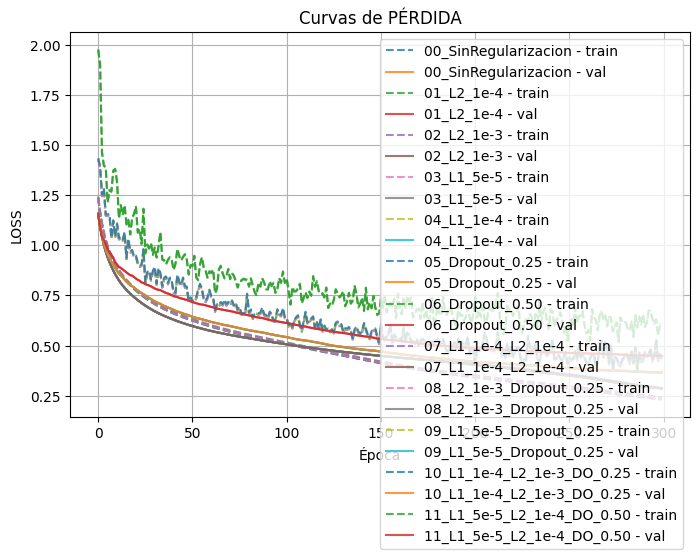

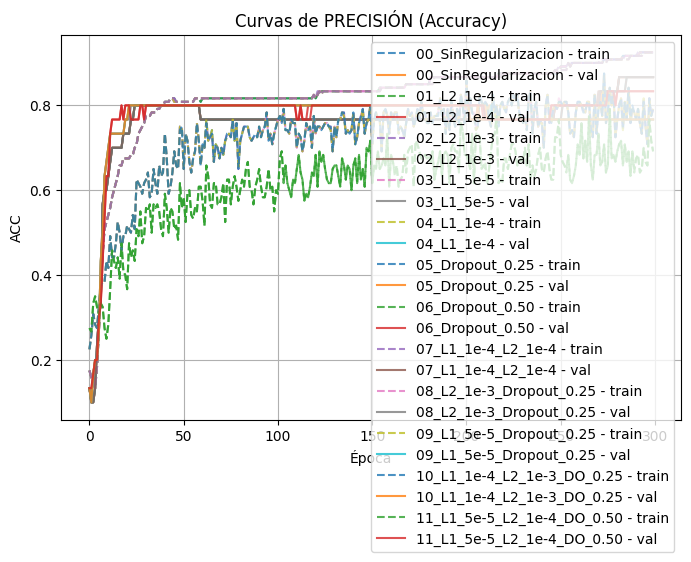

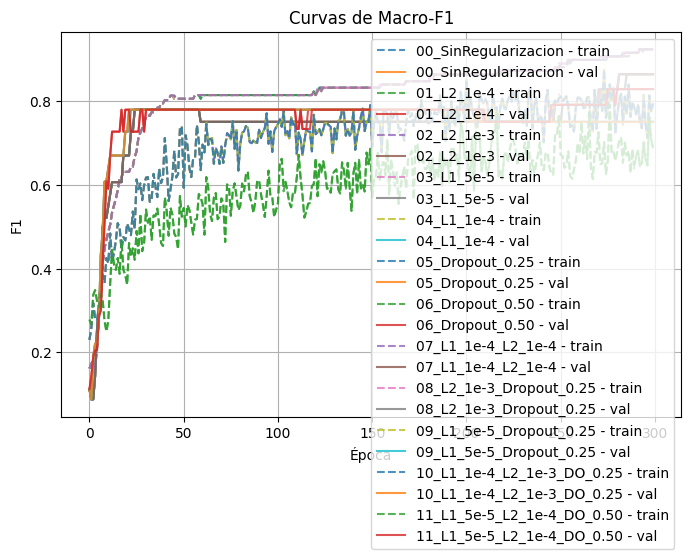

In [61]:
# ----------------- Gráficas -----------------

top_combos = [cfg["name"] for cfg in combinaciones]

def plot_metric(metric_key: str, title: str):
    plt.figure(figsize=(8,5))
    for name in top_combos:
        plt.plot(histories6[name][f"train_{metric_key}"], label=f"{name} - train", alpha=0.8, linestyle="--")
        plt.plot(histories6[name][f"val_{metric_key}"],   label=f"{name} - val",   alpha=0.8)
    plt.xlabel("Época")
    plt.ylabel(metric_key.upper())
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

plot_metric("loss", "Curvas de PÉRDIDA")
plot_metric("acc",  "Curvas de PRECISIÓN (Accuracy)")
plot_metric("f1",   "Curvas de Macro-F1")